In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # Statistical plots built on matplotlib
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


In [2]:
# ================================================================
# Import Libraries 
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # Plotting library
import seaborn as sns # Statistical plots built on matplotlib
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

In [3]:
# ================================================================
# Load Data
# ================================================================
train = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv")


#  Quick Dataset Overview 


In [4]:
print('train data shape',train.shape )
print('test data shape',test.shape )

train data shape (593994, 13)
test data shape (254569, 12)


In [5]:
print("train datatype ")
print(train.dtypes)# Data types of each column


train datatype 
id                        int64
annual_income           float64
debt_to_income_ratio    float64
credit_score              int64
loan_amount             float64
interest_rate           float64
gender                   object
marital_status           object
education_level          object
employment_status        object
loan_purpose             object
grade_subgrade           object
loan_paid_back          float64
dtype: object


In [6]:
print("test datatype ")
print(test.dtypes) # Data types of each column

test datatype 
id                        int64
annual_income           float64
debt_to_income_ratio    float64
credit_score              int64
loan_amount             float64
interest_rate           float64
gender                   object
marital_status           object
education_level          object
employment_status        object
loan_purpose             object
grade_subgrade           object
dtype: object


In [7]:
print("First 5 rows of train")
print( train.head()) # first 5 rows at the data

First 5 rows of train
   id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   
3   3       46858.25                 0.065           533      4682.48   
4   4       25496.70                 0.053           665     12184.43   

   interest_rate  gender marital_status education_level employment_status  \
0          13.67  Female         Single     High School     Self-employed   
1          12.92    Male        Married        Master's          Employed   
2           9.76    Male         Single     High School          Employed   
3          16.10  Female         Single     High School          Employed   
4          10.21    Male        Married     High School          Employed   

         loan_purpose grade_subgrade  loan_paid_back  
0               Other

In [8]:
print("First 5 rows of test")
print( test.head()) # first 5 rows at the data

First 5 rows of test
       id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0  593994       28781.05                 0.049           626     11461.42   
1  593995       46626.39                 0.093           732     15492.25   
2  593996       54954.89                 0.367           611      3796.41   
3  593997       25644.63                 0.110           671      6574.30   
4  593998       25169.64                 0.081           688     17696.89   

   interest_rate  gender marital_status education_level employment_status  \
0          14.73  Female         Single     High School          Employed   
1          12.85  Female        Married        Master's          Employed   
2          13.29    Male         Single      Bachelor's          Employed   
3           9.57  Female         Single      Bachelor's          Employed   
4          12.80  Female        Married             PhD          Employed   

         loan_purpose grade_subgrade  
0             

In [9]:
# Missing values check (column-wise counts)
print("Missing values in train:", train.isnull().sum())
print("-"*20)
print("Missing values in test:", test.isnull().sum())


Missing values in train: id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64
--------------------
Missing values in test: id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
dtype: int64


In [10]:
#Target distribution (class imbalance insight)
# Count raw numbers
print(train['loan_paid_back'].value_counts())

# Count proportions (percentages)
print(train['loan_paid_back'].value_counts(normalize=True))


loan_paid_back
1.0    474494
0.0    119500
Name: count, dtype: int64
loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64


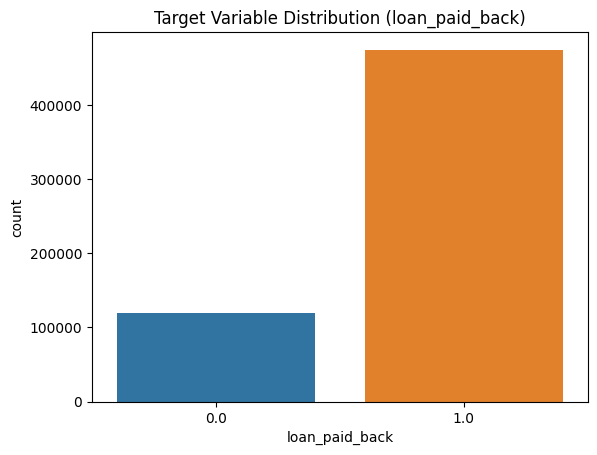

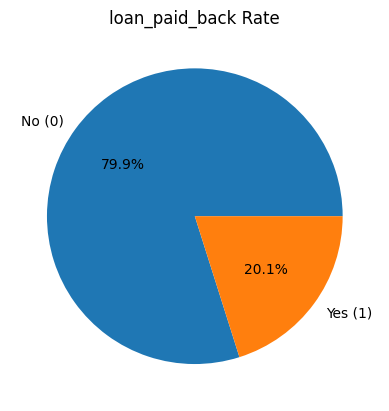

In [11]:
# Train
# Bar chart
sns.countplot(x='loan_paid_back', data=train)
plt.title("Target Variable Distribution (loan_paid_back)")
plt.show()

# Pie chart
train['loan_paid_back'].value_counts().plot.pie(autopct='%1.1f%%', labels=['No (0)','Yes (1)'])
plt.title("loan_paid_back Rate")
plt.ylabel("")
plt.show()

# Column lists for convenience

In [12]:
# Identify numeric and categorical columns based on the actual dataset schema
num_cols = ["annual_income", "debt_to_income_ratio", "credit_score", "loan_amount", "interest_rate"]  # numerical features
cat_cols = ["gender", "marital_status", "education_level", "employment_status", "loan_purpose", "grade_subgrade"]  # categorical features

#  Univariate analysis: numerical features 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


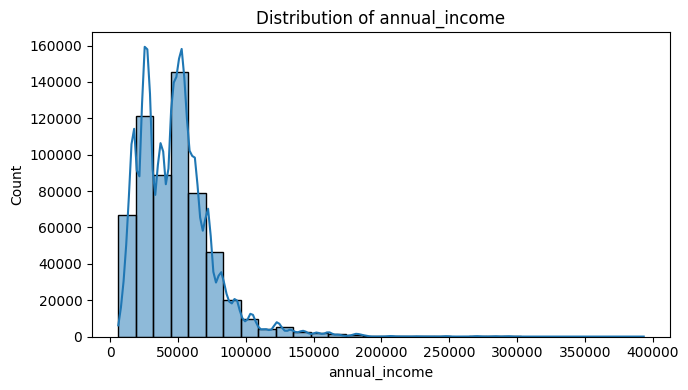

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


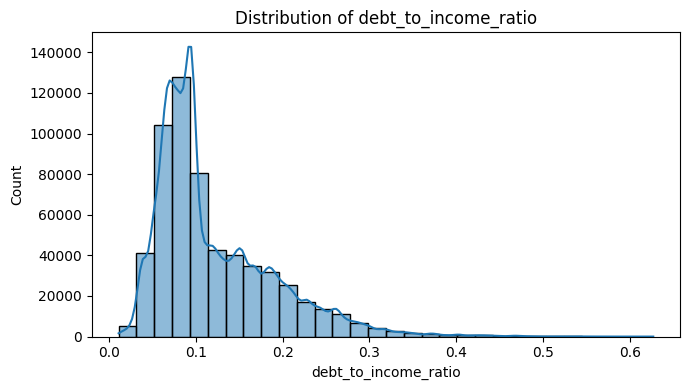

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


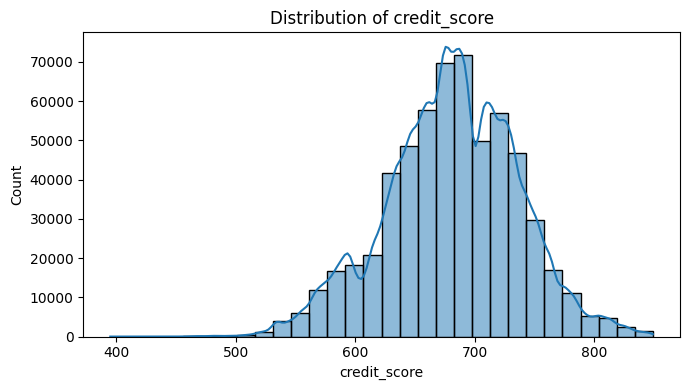

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


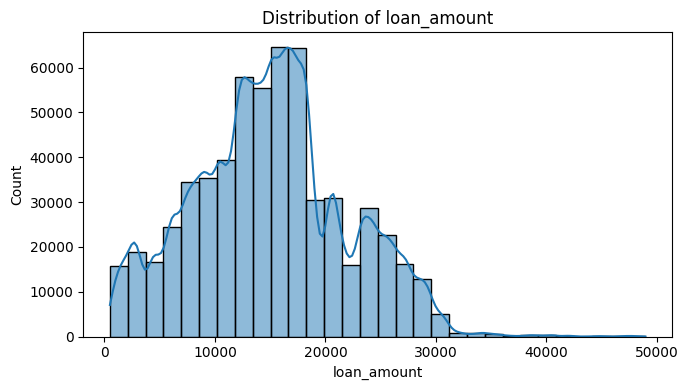

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


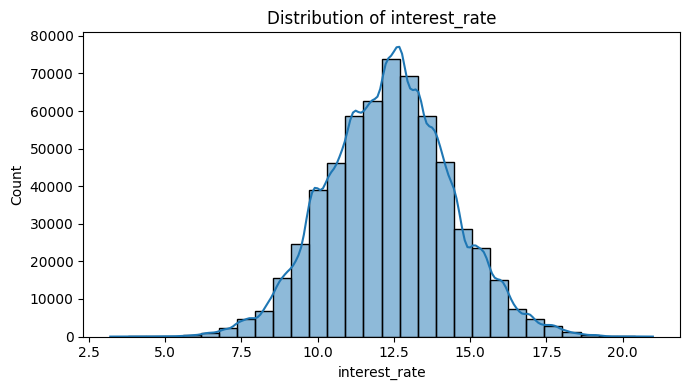

In [13]:
#train dataset
# Histograms + KDE to inspect distribution, skewness, and potential outliers
#Loops through each column in your list of numerical features (like age, balance, duration, etc.).
for col in num_cols:
    plt.figure(figsize=(7,4)) # Set figure size
    sns.histplot(train[col], bins=30, kde=True) # Histogram with density curve
    plt.title(f"Distribution of {col}") # Chart title
    plt.xlabel(col) # X axis label
    plt.ylabel("Count") # Y axis label
    plt.tight_layout() # Neat layout
    plt.show() # Render plot

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


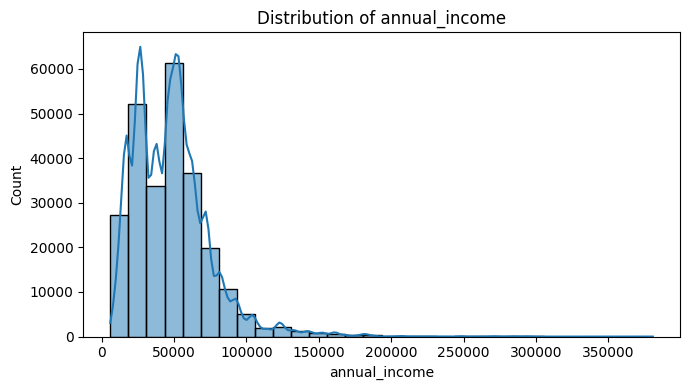

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


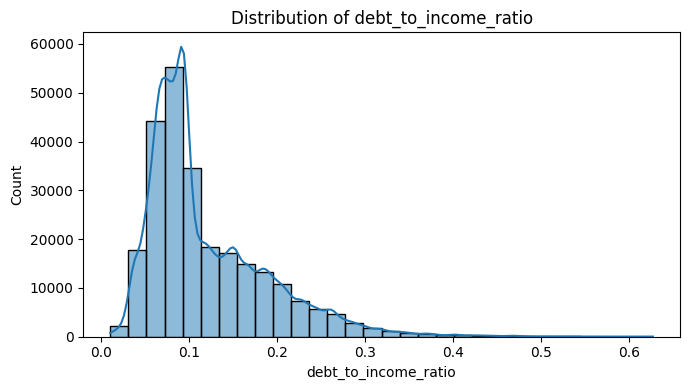

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


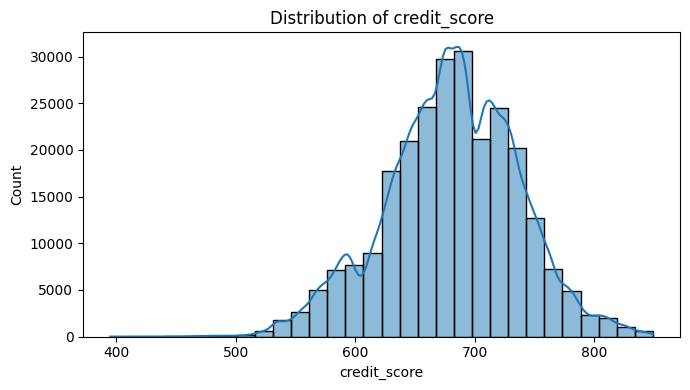

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


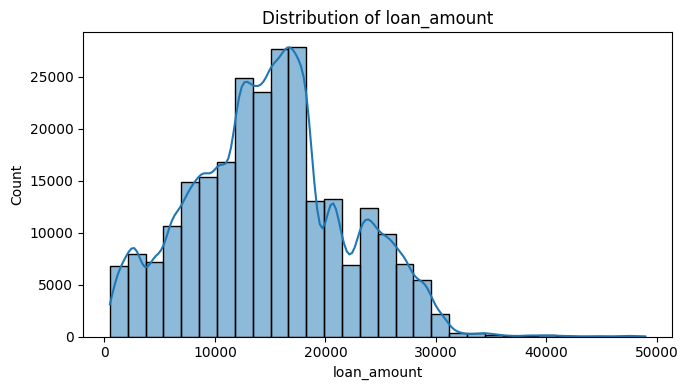

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


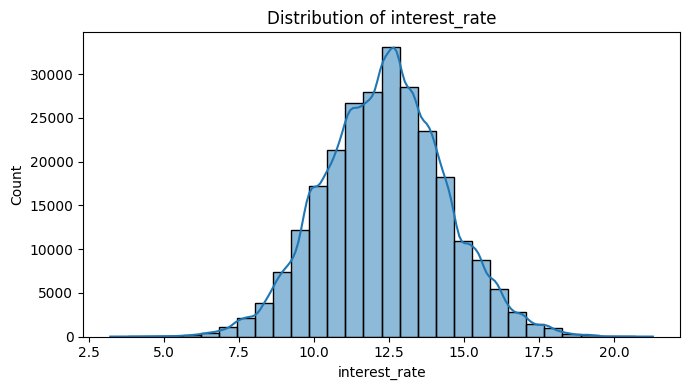

In [14]:
#test dataset
# Histograms + KDE to inspect distribution, skewness, and potential outliers
#Loops through each column in your list of numerical features (like age, balance, duration, etc.).
for col in num_cols:
    plt.figure(figsize=(7,4)) # Set figure size
    sns.histplot(test[col], bins=30, kde=True) # Histogram with density curve
    plt.title(f"Distribution of {col}") # Chart title
    plt.xlabel(col) # X axis label
    plt.ylabel("Count") # Y axis label
    plt.tight_layout() # Neat layout
    plt.show() # Render plot

#  Univariate analysis: categorical features 

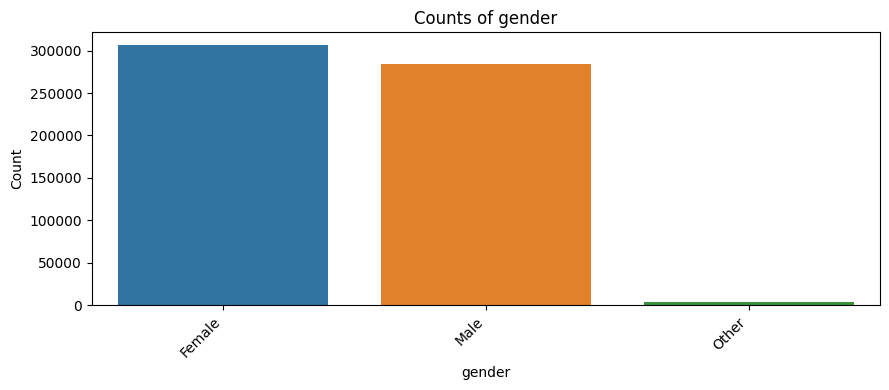

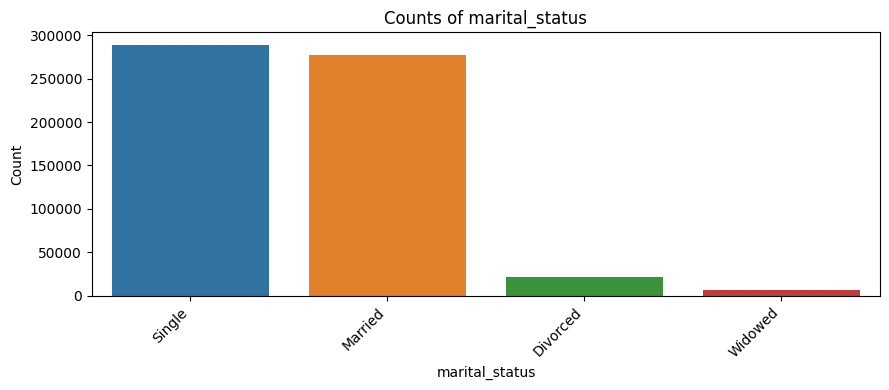

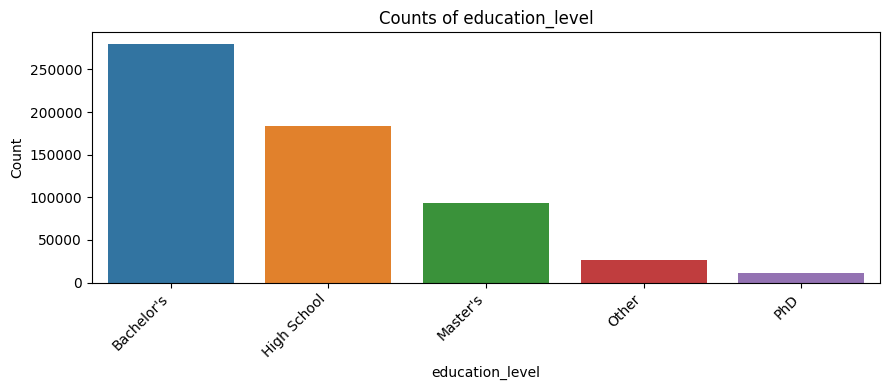

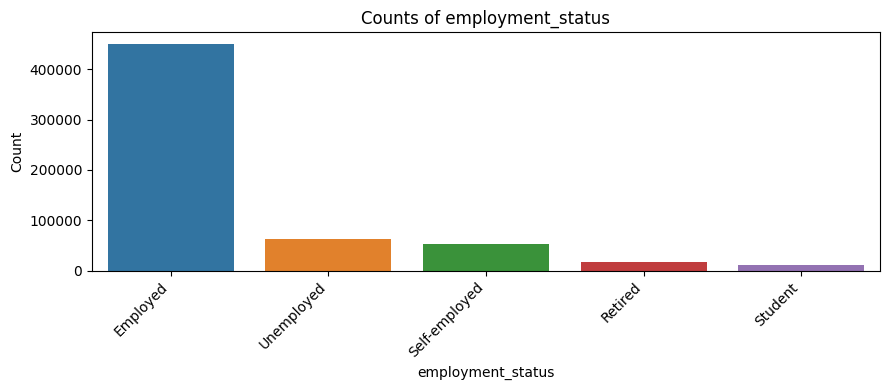

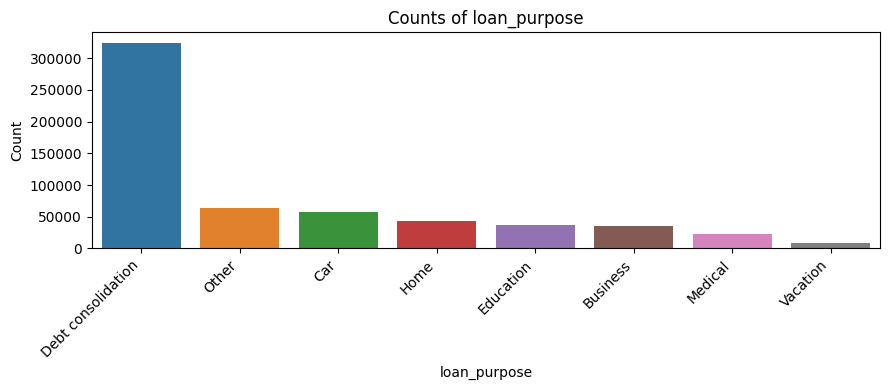

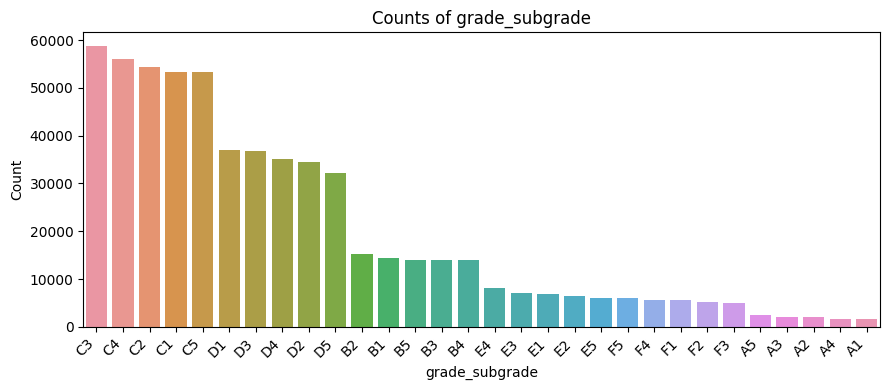

In [15]:
# train dataset
# Bar charts showing frequency of each category (ordered by count)
for col in cat_cols:
    plt.figure(figsize=(9,4)) # Set figure size
    order = train[col].value_counts().index # Order bars by frequency
    sns.countplot(data=train, x=col, order=order) # Bar plot of category counts
    plt.title(f"Counts of {col}") # Title
    plt.xlabel(col) # X label
    plt.ylabel("Count") # Y label
    plt.xticks(rotation=45, ha='right') # Rotate labels for readability
    plt.tight_layout() # Neat layout
    plt.show() # Render

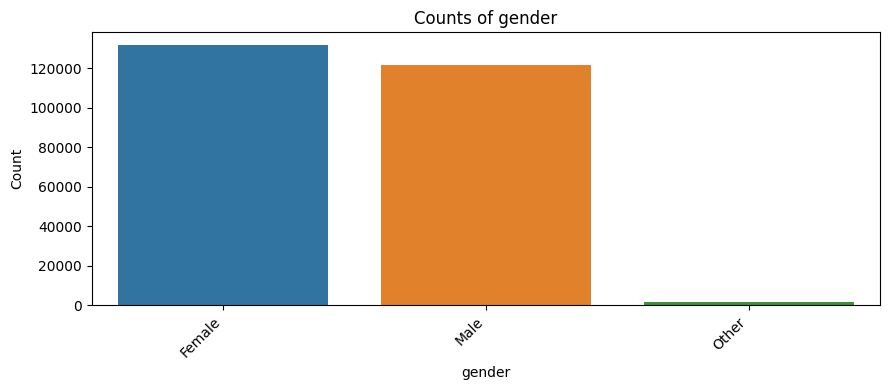

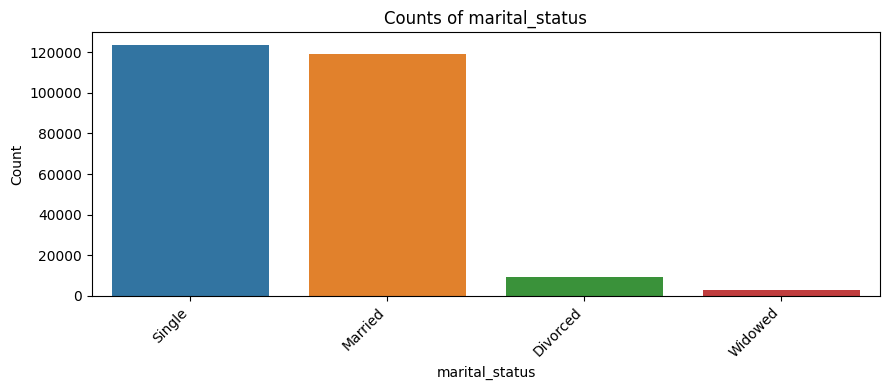

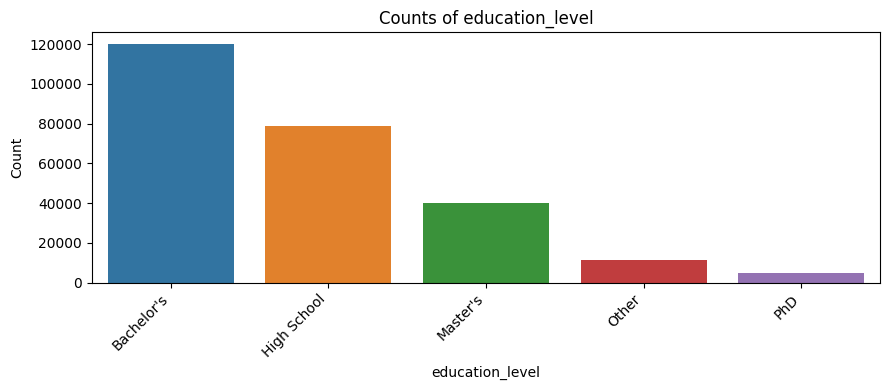

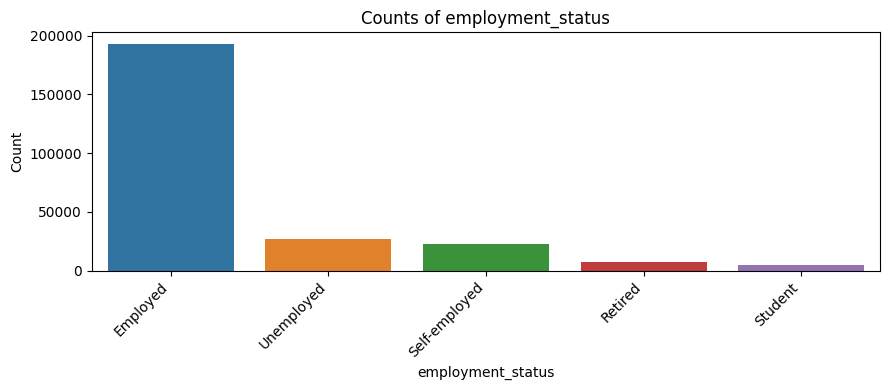

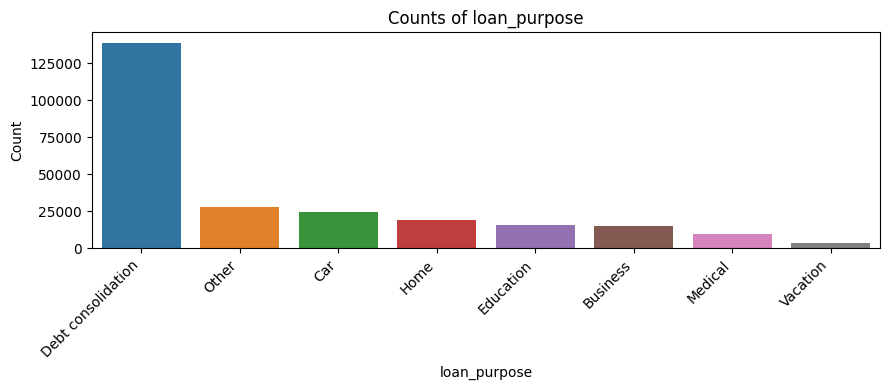

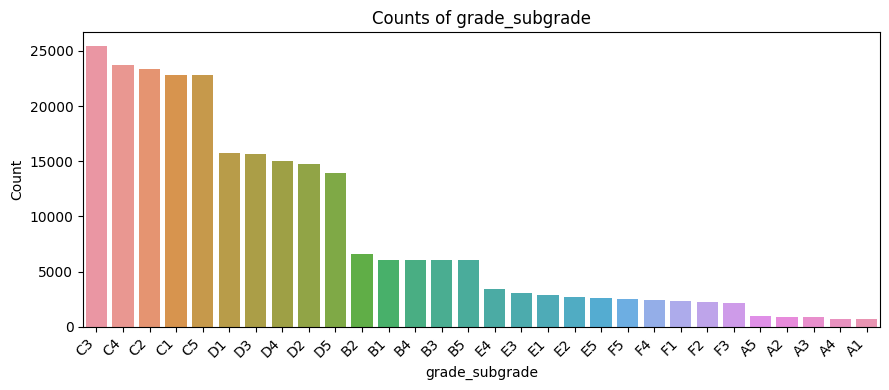

In [16]:
# test dataset
# Bar charts showing frequency of each category (ordered by count)
for col in cat_cols:
    plt.figure(figsize=(9,4)) # Set figure size
    order = test[col].value_counts().index # Order bars by frequency
    sns.countplot(data=test, x=col, order=order) # Bar plot of category counts
    plt.title(f"Counts of {col}") # Title
    plt.xlabel(col) # X label
    plt.ylabel("Count") # Y label
    plt.xticks(rotation=45, ha='right') # Rotate labels for readability
    plt.tight_layout() # Neat layout
    plt.show() # Render

#  Bivariate analysis: numeric vs target 

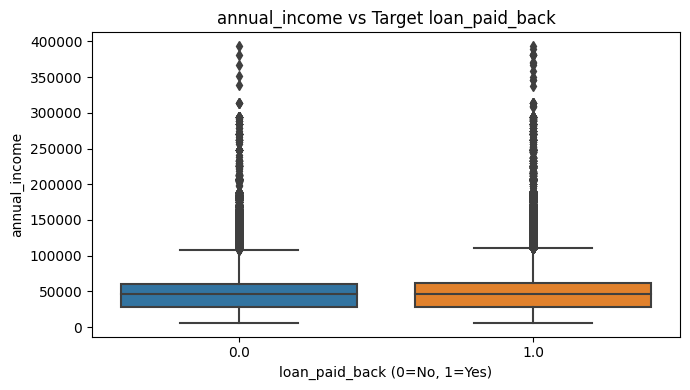

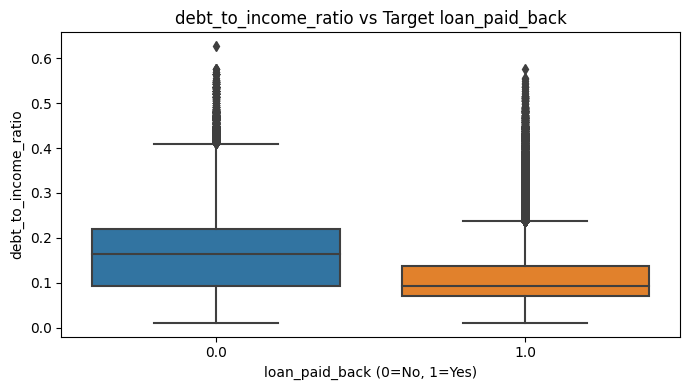

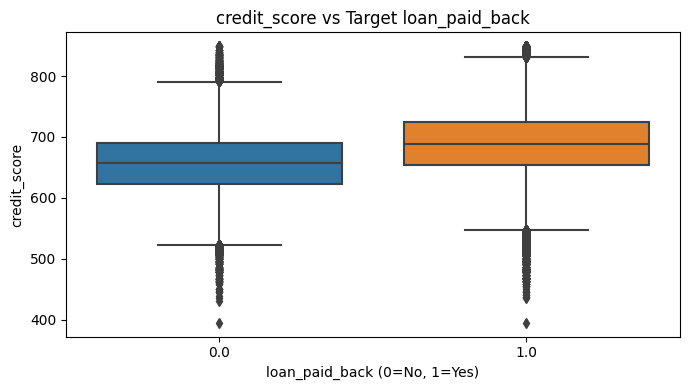

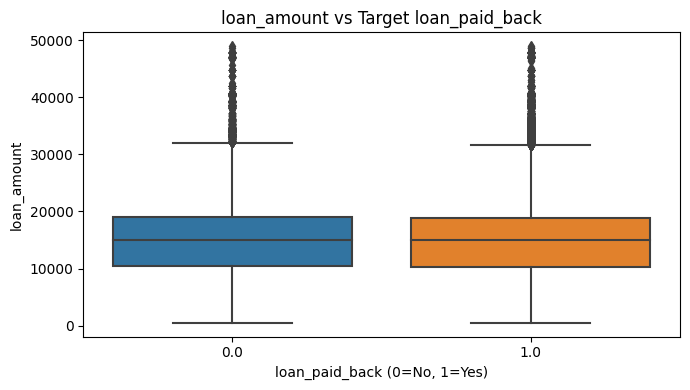

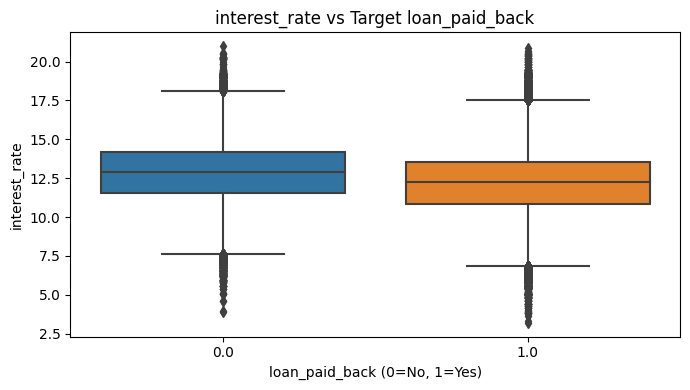

In [17]:
# Boxplots help visualize how numeric distributions differ by class loan_paid_back
for col in num_cols:
    plt.figure(figsize=(7,4)) # Figure size
    sns.boxplot(data=train, x='loan_paid_back', y=col) # Boxplot loan_paid_back~col by class
    plt.title(f"{col} vs Target loan_paid_back") # Title
    plt.xlabel("loan_paid_back (0=No, 1=Yes)") # X label
    plt.ylabel(col) # Y label
    plt.tight_layout() # Neat layout
    plt.show() # Render

#  Bivariate analysis: categorical vs target 

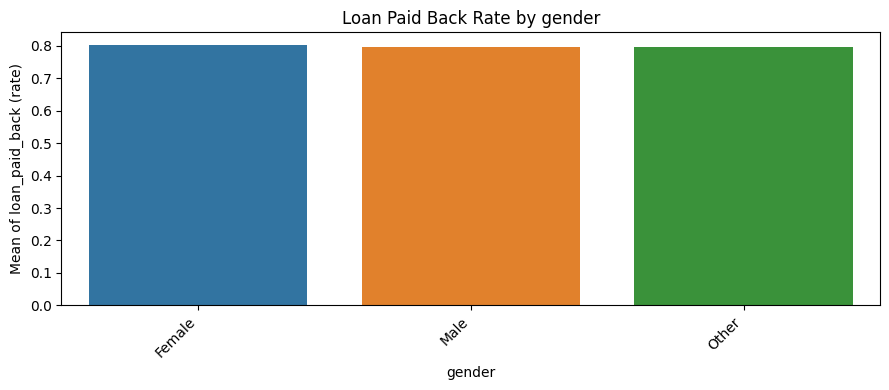

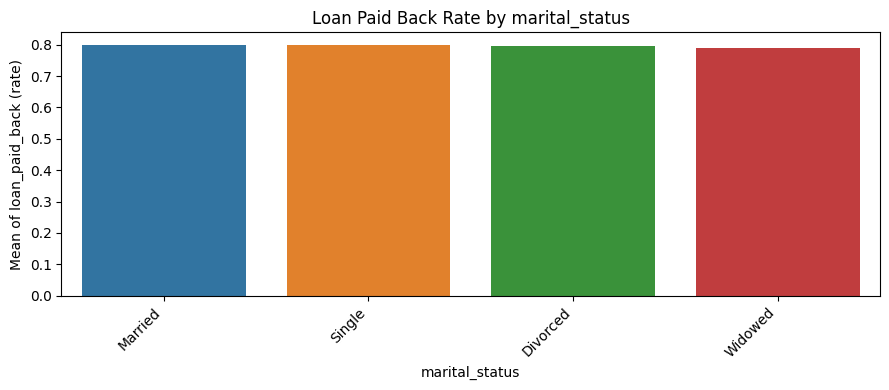

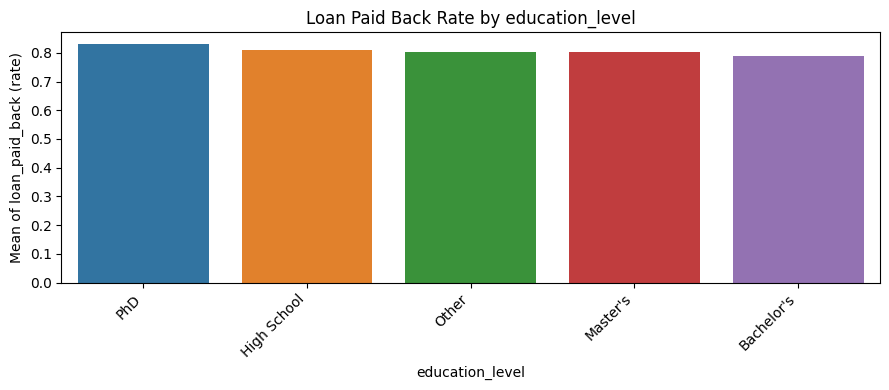

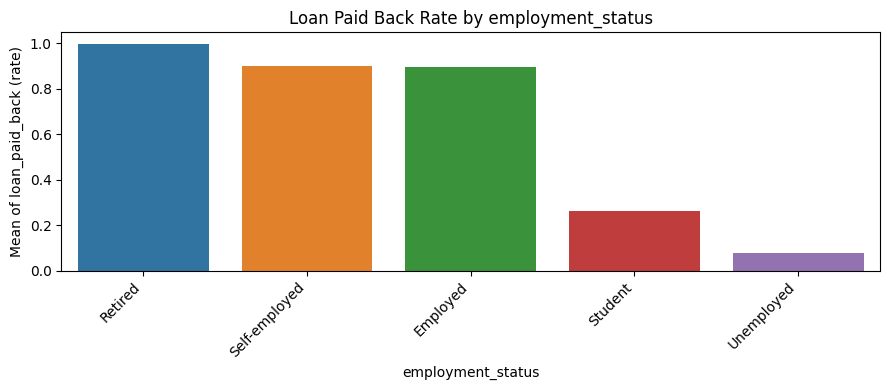

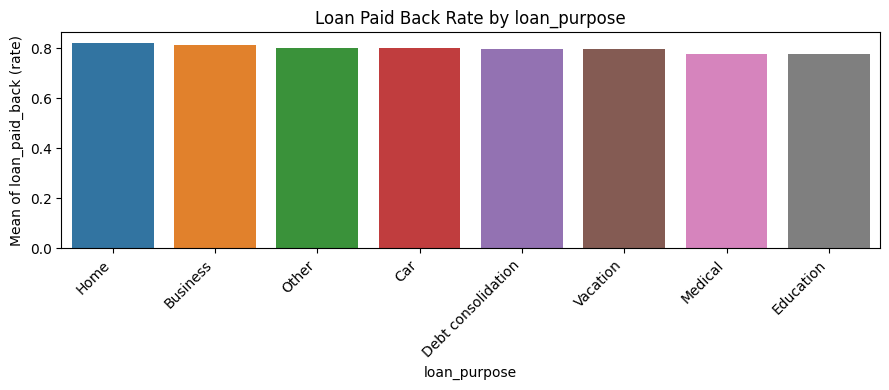

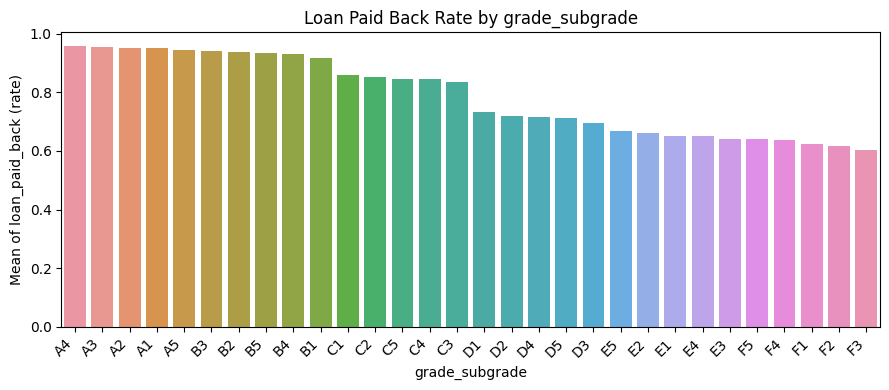

In [18]:
# Loan paid back rate (mean of loan_paid_back) per category for each categorical feature
for col in cat_cols:
# Compute mean target per category (i.e., conversion rate)
    rate = train.groupby(col)['loan_paid_back'].mean().sort_values(ascending=False)
    plt.figure(figsize=(9,4)) # Figure size
    sns.barplot(x=rate.index, y=rate.values) # Bar chart of rates
    plt.title(f"Loan Paid Back Rate by {col}") # Title
    plt.xlabel(col) # X label
    plt.ylabel("Mean of loan_paid_back (rate)") # Y label
    plt.xticks(rotation=45, ha='right') # Readable ticks
    plt.tight_layout() # Neat layout
    plt.show() # Render

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


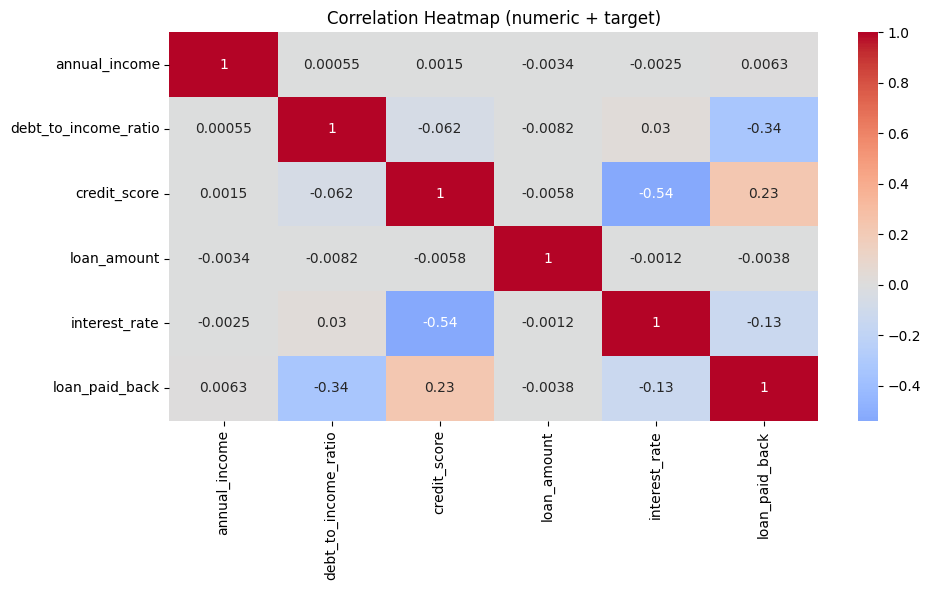

In [19]:
#train
#  Correlation analysis (numerical features only) ----
# Pearson correlations among numerical features and the target
corr = train[num_cols + ['loan_paid_back']].corr() # Compute correlation matrix
plt.figure(figsize=(10,6)) # Figure size
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0) # Heatmap with values
plt.title("Correlation Heatmap (numeric + target)") # Title
plt.tight_layout() # Neat layout
plt.show() # Render

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


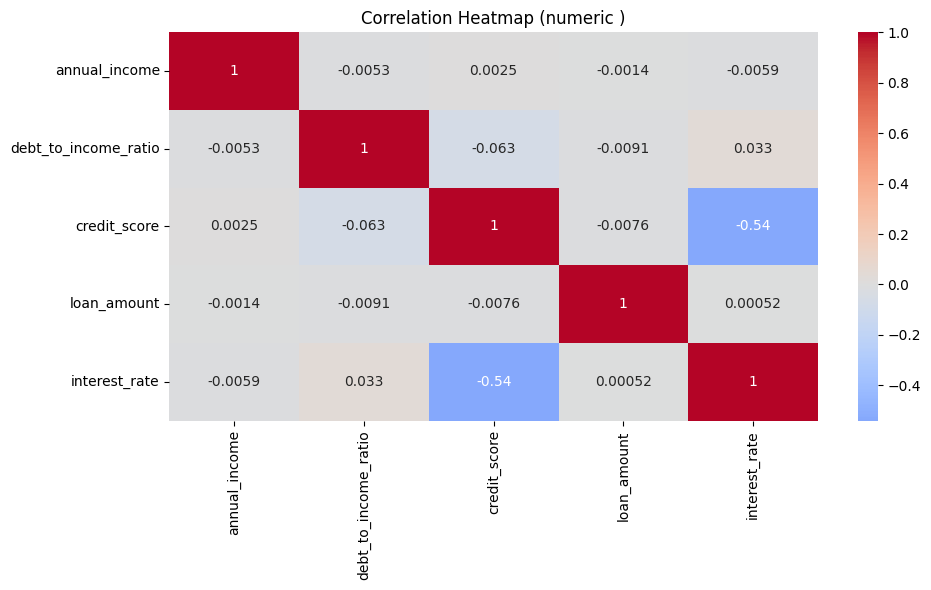

In [20]:
#test
#  Correlation analysis (numerical features only) ----
# Pearson correlations among numerical features and the target
corr = test[num_cols ].corr() # Compute correlation matrix
plt.figure(figsize=(10,6)) # Figure size
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0) # Heatmap with values
plt.title("Correlation Heatmap (numeric )") # Title
plt.tight_layout() # Neat layout
plt.show() # Render

In [21]:
#train data set 
# Store IQR outlier results in a DataFrame
iqr_outliers = []
for col in num_cols:
    q1, q3 = train[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 3 * iqr
    upper = q3 + 3 * iqr
    outliers = ((train[col] < lower) | (train[col] > upper)).sum()
    iqr_outliers.append([col, outliers, lower, upper])

train_outlier_df = pd.DataFrame(iqr_outliers, columns=["Column", "Outlier_Count", "Lower_Bound", "Upper_Bound"])
print(train_outlier_df)  

                 Column  Outlier_Count  Lower_Bound  Upper_Bound
0         annual_income           3282    -71206.36   160122.080
1  debt_to_income_ratio           1734        -0.18        0.408
2          credit_score              2       427.00      938.000
3           loan_amount            218    -15457.26    44595.460
4         interest_rate              0         2.92       21.750


In [22]:
#test data set
# Store IQR outlier results in a DataFrame
iqr_outliers = []
for col in num_cols:
    q1, q3 = test[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 3 * iqr
    upper = q3 + 3 * iqr
    outliers = ((test[col] < lower) | (test[col] > upper)).sum()
    iqr_outliers.append([col, outliers, lower, upper])

test_outlier_df = pd.DataFrame(iqr_outliers, columns=["Column", "Outlier_Count", "Lower_Bound", "Upper_Bound"])
print(test_outlier_df) 

                 Column  Outlier_Count  Lower_Bound  Upper_Bound
0         annual_income           1304    -71647.12   160746.860
1  debt_to_income_ratio            736        -0.18        0.408
2          credit_score              1       427.00      938.000
3           loan_amount            100    -15500.06    44580.100
4         interest_rate              0         2.85       21.820


# ***Encoding categorical variables***

In [23]:
#train data set 
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 1. Get categorical columns automatically (object or category dtype)
cat_cols = train.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns:", cat_cols)

# 2. Create encoder
encoder = OneHotEncoder(sparse=False, drop="first")

# 3. Fit + transform categorical data
encoded = encoder.fit_transform(train[cat_cols])

# 4. Get new column names
encoded_cols = encoder.get_feature_names_out(cat_cols)

# 5. Convert to dataframe
encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=train.index)

# 6. Drop original categorical columns and join new ones
train_encoded = train.drop(columns=cat_cols).join(encoded_df)

print(train_encoded.head())


Categorical columns: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


   id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   
3   3       46858.25                 0.065           533      4682.48   
4   4       25496.70                 0.053           665     12184.43   

   interest_rate  loan_paid_back  gender_Male  gender_Other  \
0          13.67             1.0          0.0           0.0   
1          12.92             0.0          1.0           0.0   
2           9.76             1.0          1.0           0.0   
3          16.10             1.0          0.0           0.0   
4          10.21             1.0          1.0           0.0   

   marital_status_Married  ...  grade_subgrade_E1  grade_subgrade_E2  \
0                     0.0  ...                0.0                0.0   
1                     1.0  ...        

In [24]:
train_encoded=train_encoded.drop("id", axis=1)

In [25]:
X=train_encoded

In [26]:
#test data encoding 
# step 2
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 1. Get categorical columns automatically (object or category dtype)
cat_cols = test.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns:", cat_cols)

# 2. Create encoder
encoder = OneHotEncoder(sparse=False, drop="first")

# 3. Fit + transform categorical data
encoded = encoder.fit_transform(test[cat_cols])

# 4. Get new column names
encoded_cols = encoder.get_feature_names_out(cat_cols)

# 5. Convert to dataframe
encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=test.index)

# 6. Drop original categorical columns and join new ones
test_encoded = test.drop(columns=cat_cols).join(encoded_df)

print(test_encoded.head())

Categorical columns: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


       id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0  593994       28781.05                 0.049           626     11461.42   
1  593995       46626.39                 0.093           732     15492.25   
2  593996       54954.89                 0.367           611      3796.41   
3  593997       25644.63                 0.110           671      6574.30   
4  593998       25169.64                 0.081           688     17696.89   

   interest_rate  gender_Male  gender_Other  marital_status_Married  \
0          14.73          0.0           0.0                     0.0   
1          12.85          0.0           0.0                     1.0   
2          13.29          1.0           0.0                     0.0   
3           9.57          0.0           0.0                     0.0   
4          12.80          0.0           0.0                     1.0   

   marital_status_Single  ...  grade_subgrade_E1  grade_subgrade_E2  \
0                    1.0  ...          

In [27]:
test_encoded=test_encoded.drop("id", axis=1)

In [28]:
# Combine train and test features for consistent scaling
train_features = train_encoded.drop(columns=["loan_paid_back"])
test_features = test_encoded
combined_features = pd.concat([train_features, test_features], ignore_index=True)

# Fit scaler on combined features
scaler = StandardScaler()
combined_scaled = scaler.fit_transform(combined_features)
combined_scaled_df = pd.DataFrame(combined_scaled, columns=combined_features.columns)

# Split back
X = combined_scaled_df.iloc[:len(train_features)]
X_test = combined_scaled_df.iloc[len(train_features):]

# ****Separate features and target****

In [29]:

#X = train.drop(columns=["y"])
#y = train["y"]  # binary 0/1

 # ***Standardize***

# ****Train/Validation Split****

In [30]:
#: Separate features & target ---
y = train_encoded["loan_paid_back"]

print(X.shape, y.shape)

(593994, 54) (593994,)


In [31]:
from sklearn.model_selection import train_test_split
#Train
# X and y already prepared from your train dataset
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)

Train shape: (475195, 54) (475195,)
Validation shape: (118799, 54) (118799,)


In [32]:
#Test
# X and y already prepared from your train dataset
#X_test, X_val, y_test, y_val = train_test_split(
#    X, y, test_size=0.2, random_state=42, stratify=y
#)

#print("Train shape:", X_test.shape, y_test.shape)
#print("Validation shape:", X_val.shape, y_val.shape)

# ****Models Evaluation****

In [33]:
#from sklearn.utils import class_weight

# use your actual target variable 'y'
#weights = class_weight.compute_class_weight(
 #   class_weight='balanced',
  #  classes=np.unique(y),
   # y=y
#)

#print("Class Weights:", dict(zip(np.unique(y), weights)))


In [34]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score

# Use class weights from earlier
#class_weights = [weights[0], weights[1]]

cat_model = CatBoostClassifier(iterations=2000,learning_rate=0.05,depth=6,l2_leaf_reg=5,random_seed=42,eval_metric="AUC",verbose=200)
#class_weights=class_weights,
# Train
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

# Predictions (probabilities for AUC)
cat_pred_proba = cat_model.predict_proba(X_val)[:, 1]
cat_pred = cat_model.predict(X_val)

# Metrics
print("ROC AUC Score (CatBoost):", roc_auc_score(y_val, cat_pred_proba))
print("F1 Score (CatBoost):", f1_score(y_val, cat_pred))


0:	test: 0.8996266	best: 0.8996266 (0)	total: 132ms	remaining: 4m 24s
200:	test: 0.9159637	best: 0.9159637 (200)	total: 13.8s	remaining: 2m 3s
400:	test: 0.9183023	best: 0.9183023 (400)	total: 27.4s	remaining: 1m 49s
600:	test: 0.9196036	best: 0.9196037 (598)	total: 40.6s	remaining: 1m 34s
800:	test: 0.9205492	best: 0.9205492 (800)	total: 54.1s	remaining: 1m 20s
1000:	test: 0.9210935	best: 0.9210935 (1000)	total: 1m 7s	remaining: 1m 7s
1200:	test: 0.9215410	best: 0.9215410 (1200)	total: 1m 21s	remaining: 54.2s
1400:	test: 0.9218760	best: 0.9218760 (1400)	total: 1m 34s	remaining: 40.6s
1600:	test: 0.9221546	best: 0.9221546 (1600)	total: 1m 48s	remaining: 27s
1800:	test: 0.9223191	best: 0.9223256 (1796)	total: 2m 1s	remaining: 13.4s
1999:	test: 0.9224540	best: 0.9224540 (1999)	total: 2m 15s	remaining: 0us

bestTest = 0.9224539545
bestIteration = 1999

ROC AUC Score (CatBoost): 0.9224539544596655
F1 Score (CatBoost): 0.9433782067564136


In [35]:
y_pred_proba = cat_model.predict_proba(X_test)[:, 1]

In [36]:
submission=pd.DataFrame({'id':test['id'], 'loan_paid_back':y_pred_proba})
print(submission)

            id  loan_paid_back
0       593994        0.945702
1       593995        0.980384
2       593996        0.397648
3       593997        0.932179
4       593998        0.966043
...        ...             ...
254564  848558        0.994162
254565  848559        0.817585
254566  848560        0.971148
254567  848561        0.985783
254568  848562        0.907859

[254569 rows x 2 columns]


In [37]:
submission.to_csv('submission_cat.csv',index=False)